In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import re

from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

rc('text', usetex=True)
fontsize = 26
params = {
    'font.family': 'Times New Roman ',
#     'font.weight': 150,
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize-2,
    'xtick.labelsize': fontsize-2,
    'ytick.labelsize': fontsize-2,
    'legend.fontsize': fontsize-6,
}
plt.rcParams.update(params)

In [2]:
fpath = '/home/ubuntu/code/Spectral-GNN-Benchmark/log/acc_num_hops-fb.csv'
t = pd.read_csv(fpath, engine='python')

t['s_test'] = t.apply(lambda row: row[row['metric'] + '_test'], axis=1)
t

,seed,num_hops,data,metric,model,conv,epoch_best,epoch_learn,time_learn,mem_ram_train,...,s_auroc_val,s_f1i_val,s_acc_test,s_ap_test,s_auroc_test,s_f1i_test,time_eval,mem_ram_eval,mem_cuda_eval,s_test
0,70,2,cora,s_f1i,MLP,Identity-ones,70,500,1.9273,1.184,...,94.169,76.937,69.039,76.641,92.632,73.013,0.0002,1.184,0.039,73.013
1,71,2,cora,s_f1i,MLP,Identity-ones,34,500,1.1560,1.226,...,92.991,75.277,69.277,79.812,93.636,74.307,0.0002,1.226,0.039,74.307
2,72,2,cora,s_f1i,MLP,Identity-ones,61,500,0.7630,1.226,...,93.933,76.015,67.276,75.961,93.599,73.013,0.0002,1.226,0.039,73.013
3,70,2,cora,s_f1i,DecoupledFixed,AdjiConv-ones,74,500,3.7113,1.231,...,98.342,87.269,85.755,91.269,97.400,86.876,0.0007,1.231,0.046,86.876
4,71,2,cora,s_f1i,DecoupledFixed,AdjiConv-ones,66,500,1.5968,1.273,...,98.145,87.454,87.026,93.127,98.330,88.170,0.0007,1.273,0.046,88.170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,71,20,flickr,s_f1i,DecoupledVar,FavardConv,19,500,15.0215,1.297,...,49.109,24.803,19.575,19.322,48.821,24.803,0.0031,1.297,0.229,24.803
3236,72,20,flickr,s_f1i,DecoupledVar,FavardConv,86,500,14.6362,1.300,...,59.346,31.776,29.558,27.853,59.690,32.237,0.0030,1.300,0.229,32.237
3237,70,20,flickr,s_f1i,DecoupledVar,OptBasisConv,121,500,23.0570,1.254,...,60.691,30.329,29.557,28.712,60.486,29.737,0.0073,1.254,0.372,29.737
3238,71,20,flickr,s_f1i,DecoupledVar,OptBasisConv,35,500,22.5414,1.337,...,62.234,33.224,33.019,31.112,63.446,33.750,0.0070,1.337,0.372,33.750


In [17]:
dlst = t['data'].unique()
dlst_name = {
    'cora': '\\textsc{cora}',
    'citeseer': '\\textsc{citeseer}',
    'pubmed': '\\textsc{pubmed}',
    'flickr': '\\textsc{flickr}',
    'chameleon_filtered': '\\textsc{chameleon}',
    'squirrel_filtered': '\\textsc{squirrel}',
    'actor': '\\textsc{actor}',
    'roman_empire': '\\textsc{roman}',
}
conv_repr = {
    'MLP': {'Identity-ones': 'Identity',},
    'DecoupledFixed': {
        'AdjiConv-ones':    'Linear',
        'AdjConv-impulse':  'Impulse',
        'AdjConv-mono':     'Monomial',
        'AdjConv-appr':     'PPR',
        'AdjConv-hk':       'HK',
        'AdjConv-gaussian': 'Gaussian',},
    'DecoupledVar': {
        'AdjiConv':         'Var-Lin',
        'AdjConv':          'Var-Mono',
        'HornerConv':       'Horner',
        'ChebConv':         'Chebyshev',
        'ClenshawConv':     'Clenshaw',
        'ChebIIConv':       'ChebInterp',
        'BernConv':         'Bernstein',
        'LegendreConv':     'Legendre',
        'JacobiConv':       'Jacobi',
        'FavardConv':       'Favard',
        'OptBasisConv':     'OptBasis',},
    # 'AdaGNN': {'LapiConv':  'AdaGNN',},
    #     'OptBasisConv':     'OptBasisGNN',},
    # 'ACMGNN': {'ACMConv-2.0-low-high-id':  'ACMGNN',}
        # 'ACMConv-1.0-low-high':     'FBGNNI',
        # 'ACMConv-2.0-low-high':     'FBGNNII',
        # 'ACMConv-1.0-low-high-id':  'ACMGNNI',
        # 'ACMConv-2.0-low-high-id':  'ACMGNNII',},
    # 'DecoupledFixedCompose': {
    #     'AdjiConv,AdjiConv-ones,ones': 'FAGNN',
    #     'Adji2Conv,Adji2Conv-gaussian,gaussian': 'G$^2$CN',
    #     'AdjDiffConv,AdjDiffConv-appr,appr': 'GNN-LF/HF',},
    # 'DecoupledVarCompose': {
    #     'AdjConv,ChebConv,BernConv': 'FiGURe',}
}

def reverse_name(name):
    for k, m in conv_repr.items():
        for c, n in m.items():
            if n == name:
                return k, c
    return None, None

flst = []
for m in conv_repr.values():
    for c, name in m.items():
        flst.append(name)

id_cols = ["seed", 'num_hops', 'data', 'model', 'conv',]
m_cols = ['s_test', ]

def get_df(t):
    tt = t[t['data'].isin(dlst)][id_cols+m_cols].sort_values(by=['data', 'num_hops', 'model', 'conv', 'seed'])
    # print(tt.sort_index(ascending=False).groupby(['data', 'model', 'conv']).filter(lambda x: len(x) > 10))
    df = tt.groupby(['data', 'num_hops', 'model', 'conv'])[m_cols].agg(['mean', 'std'])
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df.reset_index(inplace=True)

    df['name'] = df.apply(lambda row: conv_repr[row['model']][row['conv']] if (row['model'] in conv_repr) and (row['conv'] in conv_repr[row['model']]) else None, axis=1)
    df.dropna(subset=['name'], inplace=True)
    df.drop(columns=['model', 'conv'], inplace=True)
    df = df[['data', 'num_hops', 'name'] + df.columns.tolist()[2:-1]]
    return df

df = get_df(t)
df

,data,num_hops,name,s_test_mean,s_test_std
0,actor,2,PPR,36.118333,0.948815
1,actor,2,Gaussian,37.675333,1.299912
2,actor,2,HK,36.864000,1.220723
3,actor,2,Impulse,29.912333,0.362350
4,actor,2,Monomial,33.772333,1.624057
...,...,...,...,...,...
1432,squirrel_filtered,20,Horner,36.711667,1.369772
1433,squirrel_filtered,20,Jacobi,36.636333,1.915680
1434,squirrel_filtered,20,Legendre,35.811000,1.963225
1435,squirrel_filtered,20,OptBasis,33.633667,3.187822


## Plot

In [18]:
issave = True
cm20 = plt.cm.tab20(np.arange(0, 20))
cm2 = plt.cm.Set2(np.arange(0, 8))
cm3 = plt.cm.Set3(np.arange(0, 12))

In [19]:
argdct_fix = {
    'Identity':     {'color': cm2[7], 'ls': ':'},
    'Linear':       {'color': cm3[0], 'ls': '-',  'marker': '*'},
    'Impulse' :     {'color': cm3[2], 'ls': '-',  'marker': 's'},
    'Monomial':     {'color': cm3[3], 'ls': '-',  'marker': 'P'},
    'PPR':          {'color': cm3[4], 'ls': '-',  'marker': 'X'},
    'HK':           {'color': cm3[5], 'ls': '-',  'marker': 'v'},
    'Gaussian':     {'color': cm3[6], 'ls': '-',  'marker': 'o'},
}
argdct_var = {
    'Var-Lin':      {'color': cm3[0], 'ls': '-', 'marker': '*'},
    'Var-Mono':     {'color': cm3[3], 'ls': '-', 'marker': 'P'},
    'Horner':       {'color': cm3[3], 'ls': '--', 'marker': 'X'},
    'Chebyshev':    {'color': cm3[4], 'ls': '-', 'marker': '^'},
    'Clenshaw':     {'color': cm3[4], 'ls': '--', 'marker': 'v'},
    'ChebInterp':   {'color': cm3[8], 'ls': '--', 'marker': 'o'},
    'Bernstein':    {'color': cm3[5], 'ls': '-', 'marker': 'p'},
    'Legendre':     {'color': cm3[7], 'ls': '-', 'marker': 'D'},
    'Jacobi':       {'color': cm3[6], 'ls': '-', 'marker': 's'},
    'Favard':       {'color': cm3[2], 'ls': '--', 'marker': '<'},
    'OptBasis':     {'color': cm3[2], 'ls': '-', 'marker': '>'},
}

# list(enumerate(flst))

In [20]:
def plot_acchop(data, argdct, ylim=None, loc=3):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7), dpi=(150 if issave else 72))
    args = {'markersize': 16, 'linewidth': 4}
    for k, argk in argdct.items():
        dfk = df[(df['data']==data) & (df['name']==k)]
        s_test = dfk['s_test_mean']
        # modl, conv = reverse_name(k)
        # s_test = t[(t['data']==data) & (t['model']==modl) & (t['conv']==conv) & (t['seed']==70)]['s_test']
        if k == 'Identity':
            s_test = np.array([s_test.mean()]*len(s_test))
        ax.plot(dfk['num_hops'], s_test, label=k,
                **argk, **args)

    if ylim is not None:
        ax.set(ylim=ylim)
    else:
        mean = t[t['data']==data]['s_test'].median()
        std = t[t['data']==data]['s_test'].std()
        y0, y1 = ax.get_ylim()
        y0 = max(y0, mean - 2 * std)
        ax.set(ylim=[y0, y1])
    ax.set(xlim=[1.5, 20.5],
        xlabel='Hop $K$', ylabel='Test (\\%)')
    ax.set_xticks(dfk['num_hops'])
    ax.set_xticklabels(dfk['num_hops'])

    ax.grid(True, which='both', axis='y', ls='--')
    ax.grid(True, axis='x', ls='--')
    ax.legend(ncol=4, loc=loc,
             columnspacing=0.5, handlelength=1.4, handletextpad=0.3)
    # ax.set_title(data)
    return fig, ax

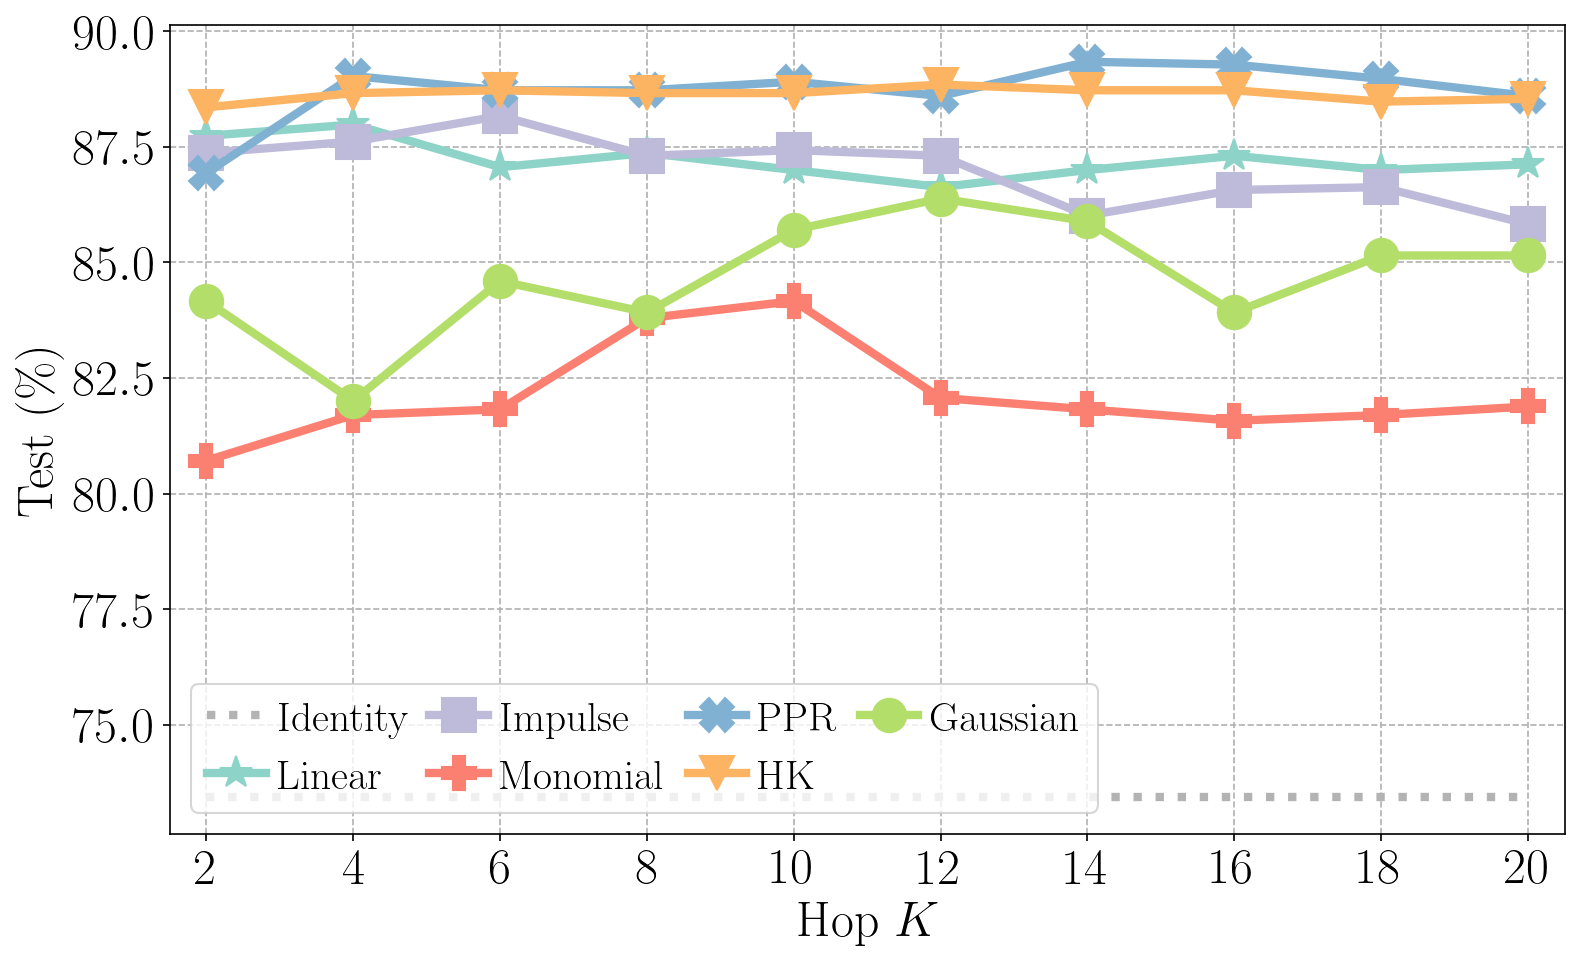

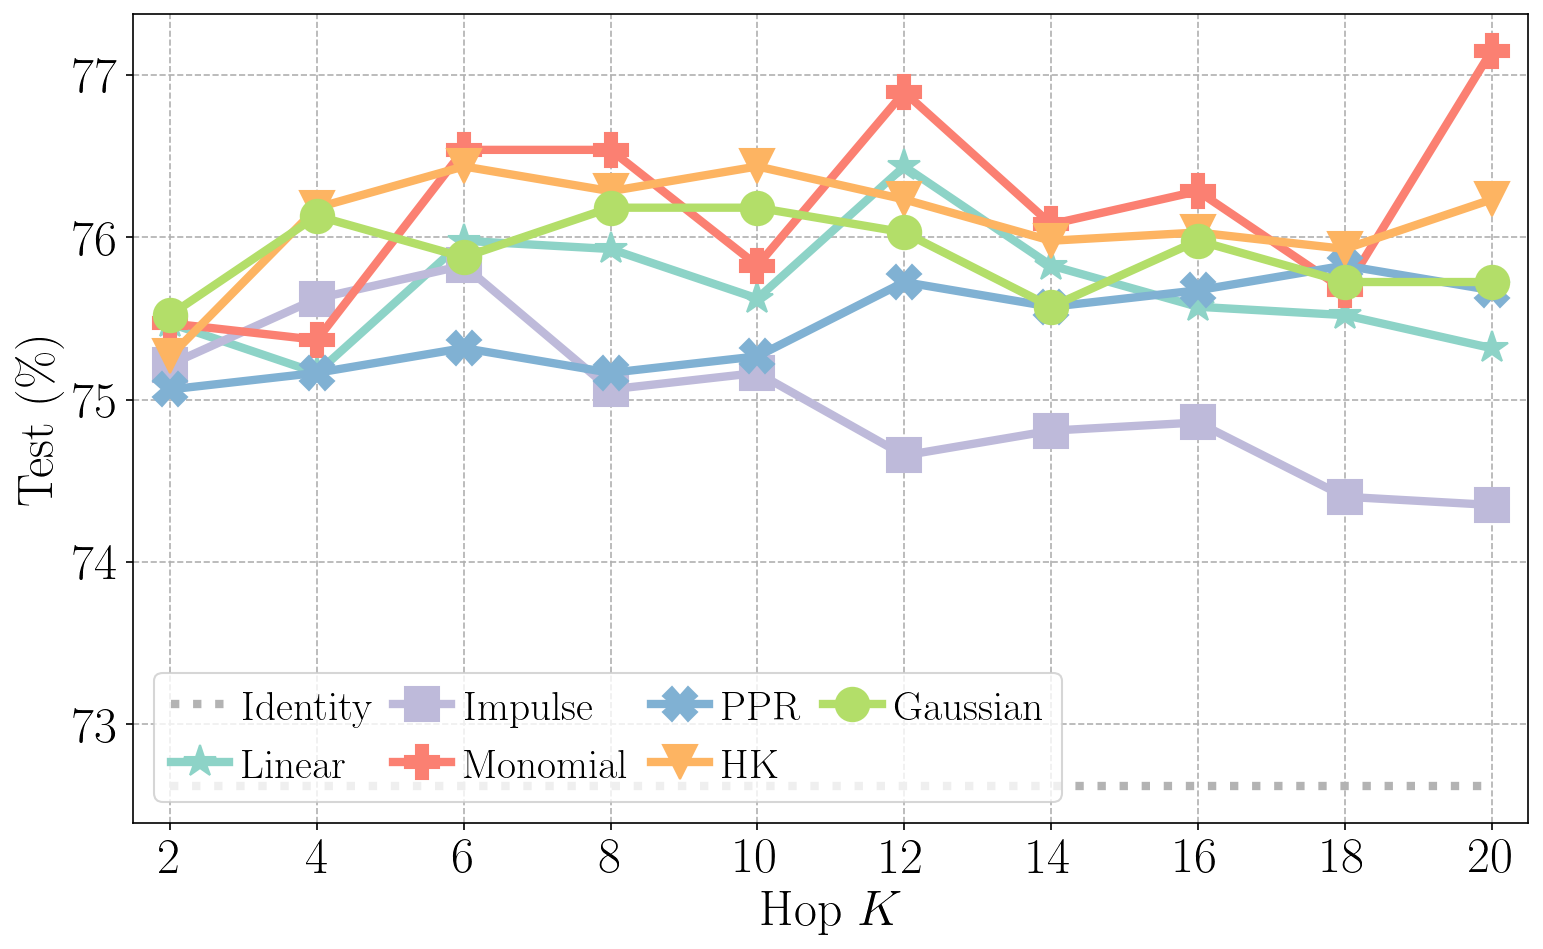

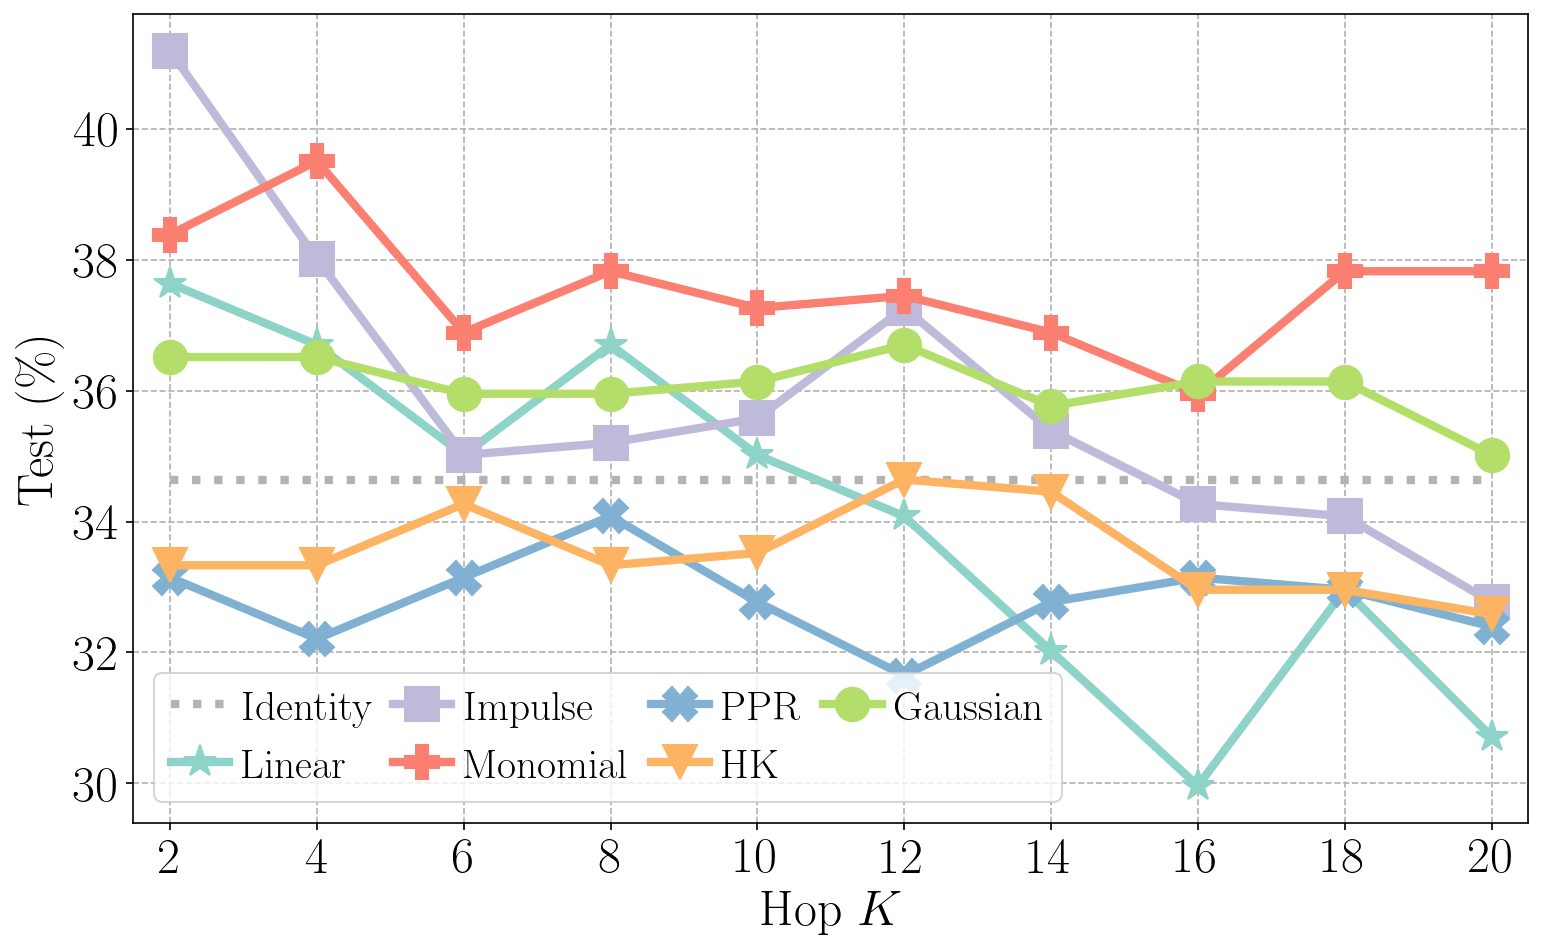

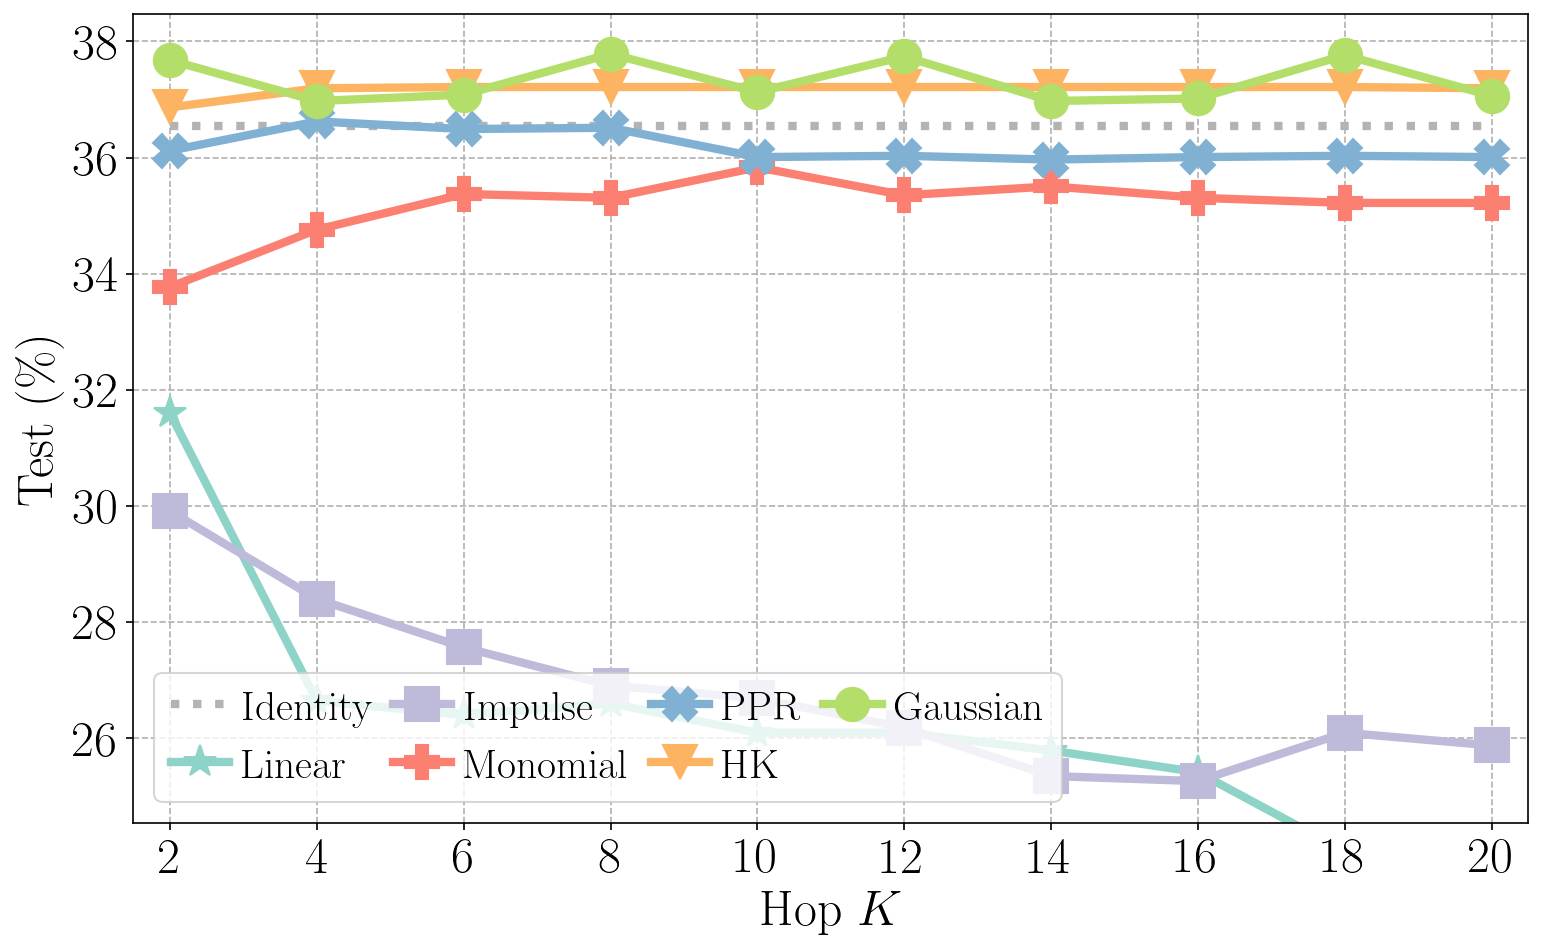

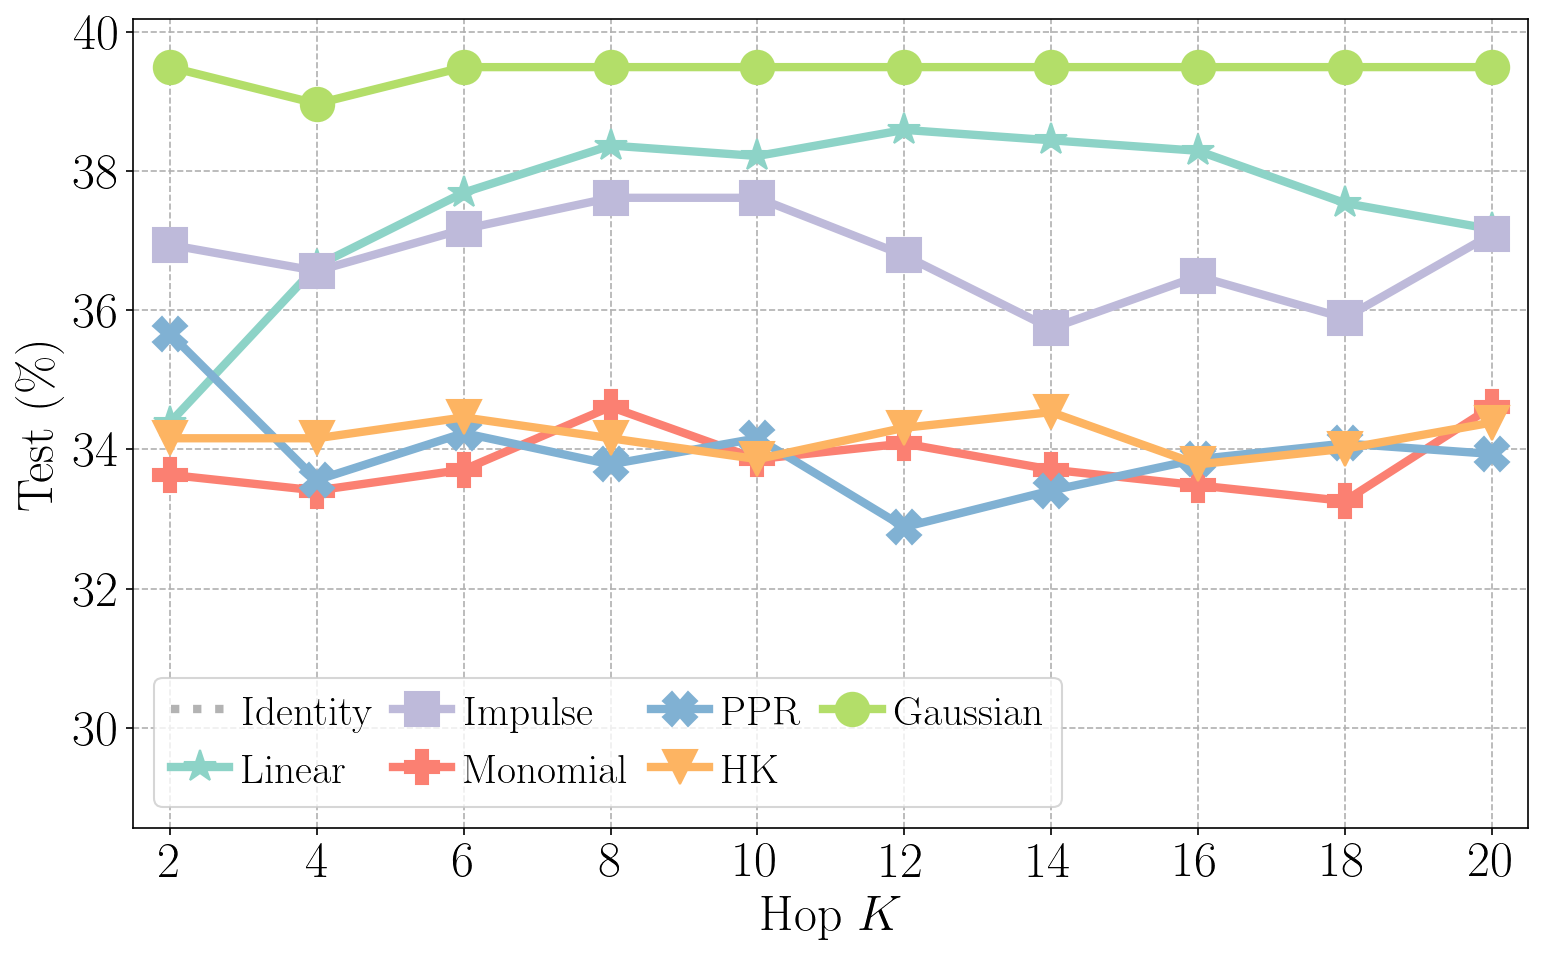

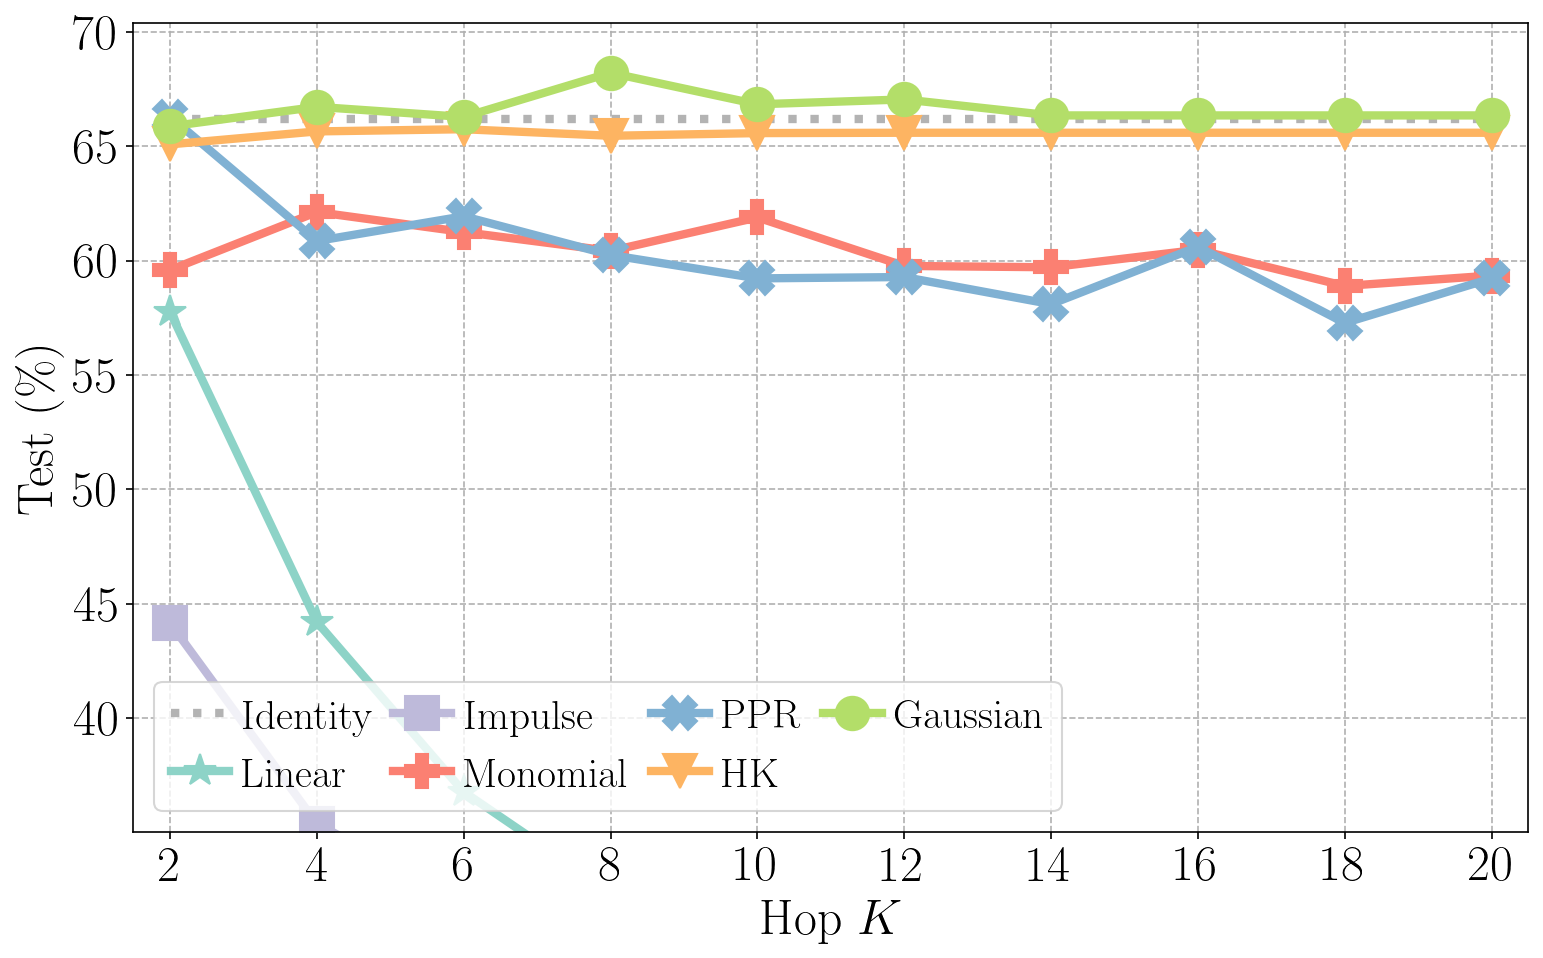

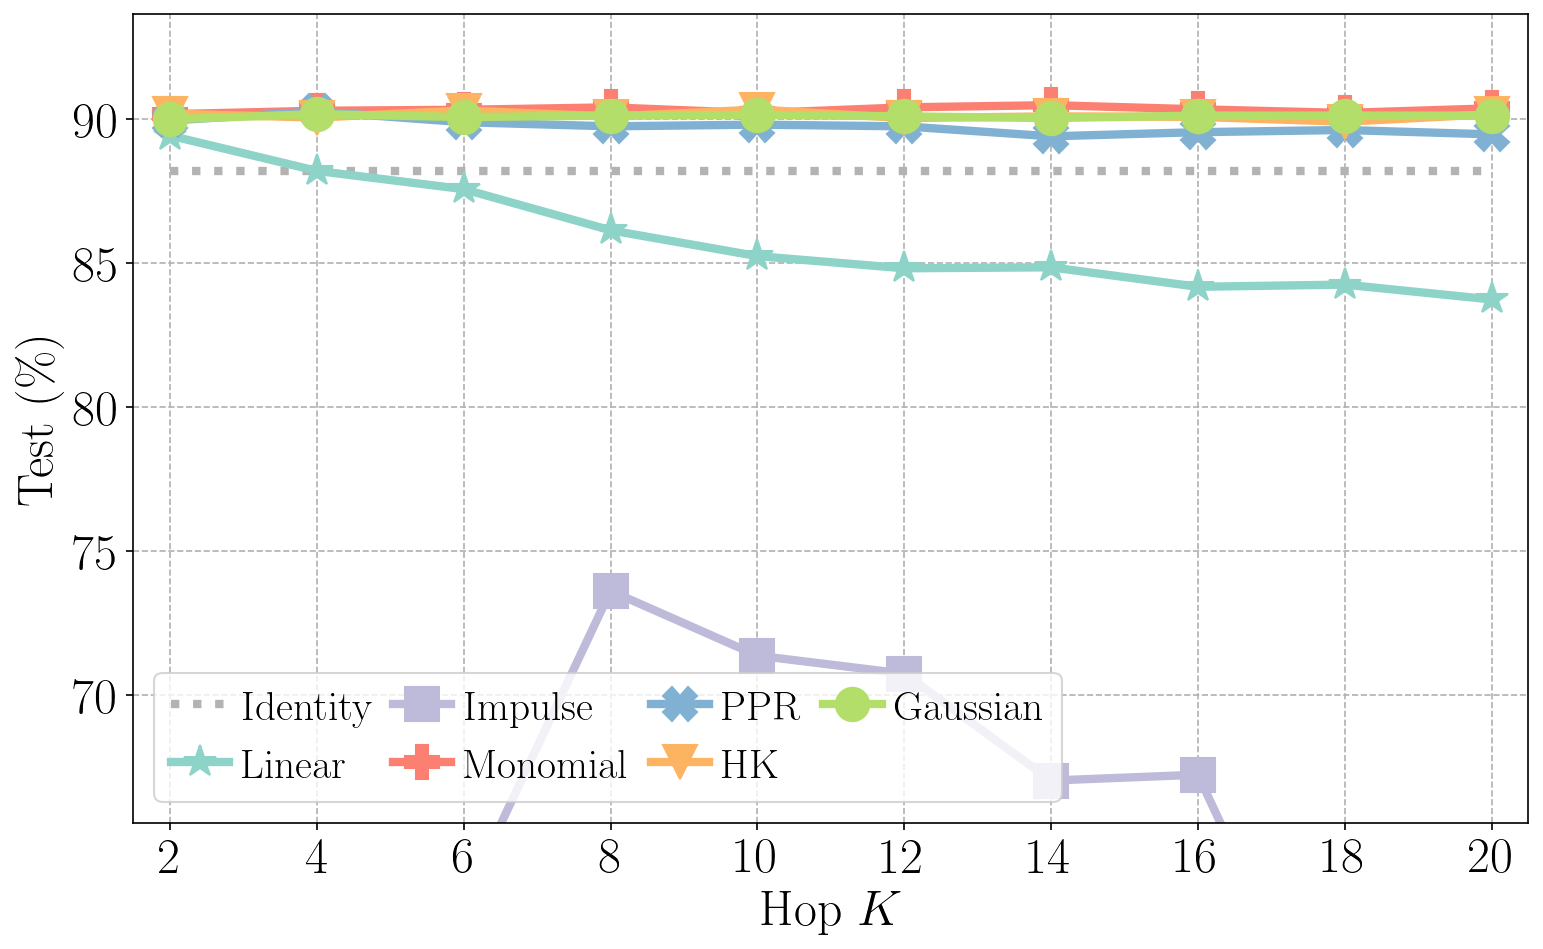

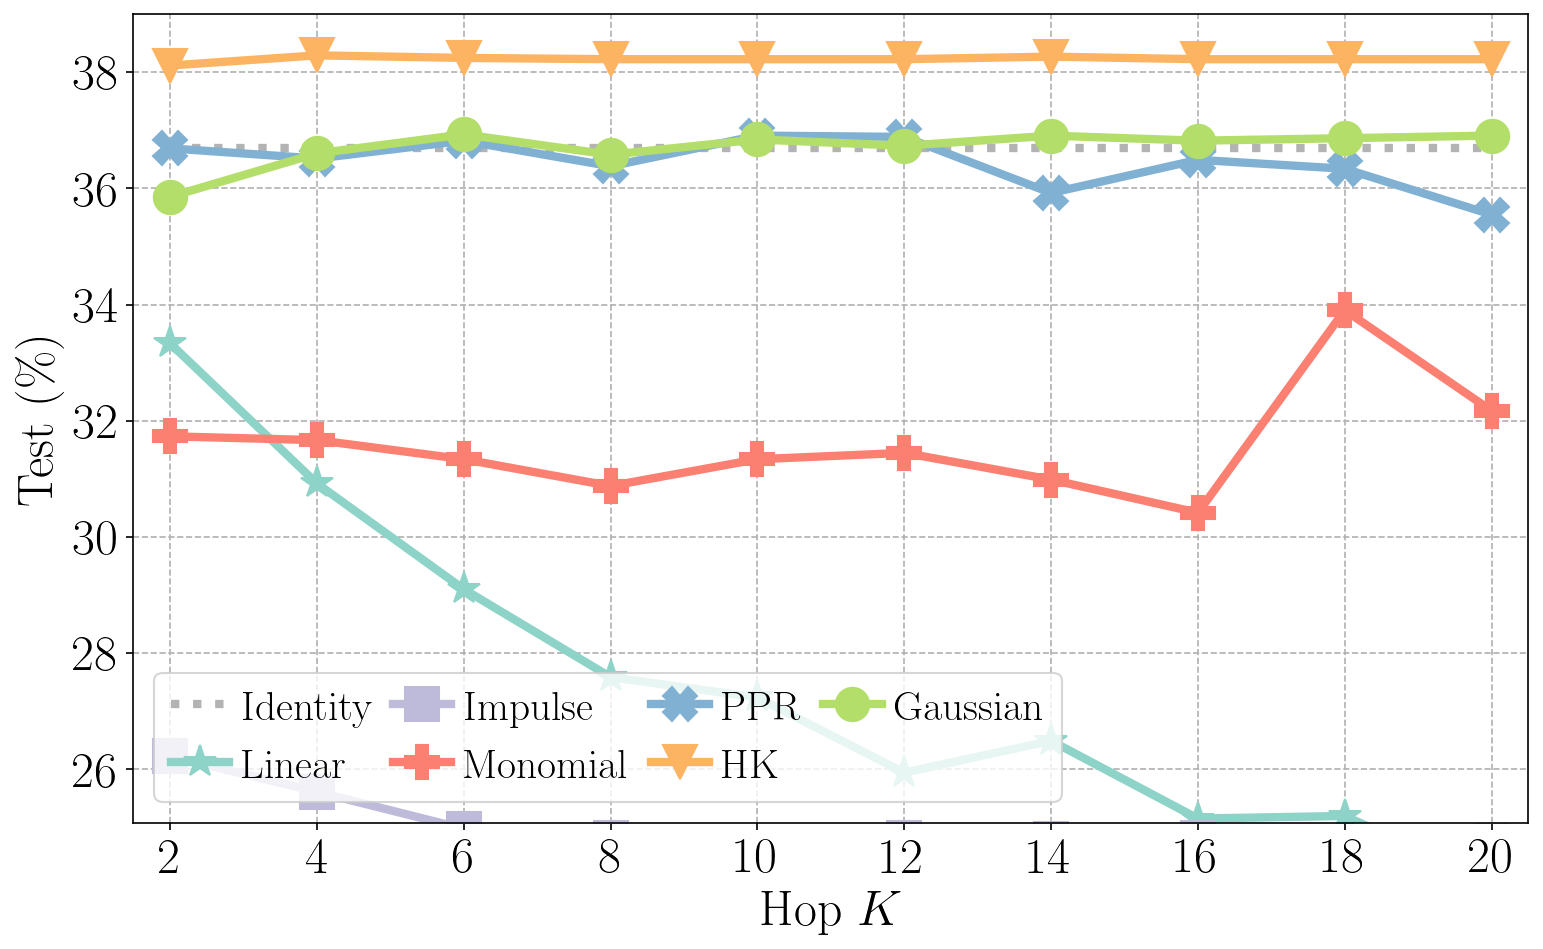

In [23]:
for d in dlst:
    fig1, ax1 = plot_acchop(d, argdct_fix)
    fig2, ax2 = plot_acchop(d, argdct_var)
    if issave:
        fig1.savefig(f'./figs/hop_fix_{d}.pdf', bbox_inches='tight')
        fig2.savefig(f'./figs/hop_var_{d}.pdf', bbox_inches='tight')